# Climate risk on a quantum computer

## Introduction

Climate change is impacting all of us. More and more are we experiencing its effects and it is expected that the climate will only keep changing.
This means that the climate is no longer a stable factor, making climate risk assessment increasingly harder.

Climate risk can be thought of as risk caused by (extreme) weather events, for example floodings, or draughts, see the figure. These events occur with a probability that is usually unknown and must be estimated. The estimation of these probabilities remains a story for another time (hint: climate models are complex), for now we act as if these probabilities are given. The exercise becomes even more complex when taking into account the _transition probabilities_, that arise when weather events follow up on each other. For example, buildings might flood with a certain probability, but when there is a large flooding in the area, the probability that the building will flood increases. Besides the probabilities, the risk events also have a (financial) impact associated with them. Classically, one would create the risk model and every extra risk item would exponentially increase the size of the problem.

![climaterisk-small.png](assets/climaterisk-small.png)

When there are probabilities and exponential classical costs present, one might start to explore the world of quantum computing. Quantum computers are probabilistic by nature and offer a speed-up for some problems. In this blog, we will look at climate risk modelling on a quantum computer and get hands-on with implementing it on IBM's Aer quantum simulator using Qiskit.

## Probabilities on a quantum computer

Quantum computers are fundamentally different than classical computers. A quantum computer uses quantum mechanics in three ways: superposition, entanglement and interference. Here, we focus mostly on superposition.
A quantum bit, or qubit, can be expressed as a $|0\rangle $ or a $|1 \rangle $, like the binary representations of a classical bit 0 and 1. Unlike the classical bit, a qubit can also be a linear combination of the two:

$$ |\psi\rangle = \alpha |0\rangle + \beta |1\rangle, $$

where $|\psi\rangle$ is the _quantum state_ of the qubit and $\alpha, \beta \in \mathbb{C}$ complex amplitudes, such that $|\alpha|^2 + |\beta|^2=1$. The last condition is called _normalisation_. When the quantum state $|\psi\rangle$ has both a factor $|0\rangle$ and $|1\rangle$, one might think of this as the qubit being in two states at the same time and this is called superposition.

Unfortunately for us, the total quantum state $|\psi\rangle$ cannot be measured directly. When measuring, only the $|0\rangle$ or the $|1\rangle$ state can be measured, and fortunately, we know the probabilities of measuring $|0\rangle$ or the $|1\rangle$. These correspond directly to the amplitudes of the vectors, by

$$ P(\text{measuring } |0\rangle) = |\alpha|^2, P(\text{measuring } |1\rangle) = |\beta|^2 .$$

This means we can encode a probability $P$ in a quantum computer, by carefully choosing $ \beta = \sqrt{P}$. Now the probability of measuring the $|1\rangle$ state is exaclty $P$. Note that consequently, the probability of measuring the $|0\rangle$ state is $1-P$ and $\alpha = \sqrt{1-P}$. 

### Rotation around the Bloch-sphere

How can we encode the probability $P$ in our qubit? How can we specify a certain $\beta$? To do this, one can use an $X$-rotation gate, i.e. a $R_X(\theta)$-gate. The $R_X(\theta)$-gate will bring a qubit that's starting in the $|0\rangle$ to the state

$$ R_X(\theta) |0\rangle = \cos{\theta/2} |0\rangle - i \sin{\theta/2} |1\rangle , $$

which we can alter in order to get the desired result. By setting $\theta = 2 \sin^{-1}\sqrt{P}$, the probability of measuring the qubit in the $|1\rangle$ state is exactly $P$. Note that a $R_Y(\theta)$ rotation would also do the job.

This fact can be demonstrated on a quantum computer using qiskit and python, see [qiskit's webpage](https://qiskit.org/documentation/getting_started.html) to get started with qiskit.

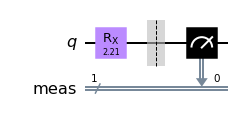

In [1]:
import qiskit as q
import numpy as np

# Create the quantum circuit with 1 qubit
circuit = q.QuantumCircuit(1)

p = 0.8  # probability of 0.2
theta = 2 * np.arcsin(np.sqrt(p))  # from p to theta

# Add the x-rotation gate to qubit 0
circuit.rx(theta, 0)

# Measure the qubits to get the output
circuit.measure_all()

# Draw the circuit with matplotlib
circuit.draw(output='mpl')

Now we have a quantum circuit `circuit` and we know what it looks like. We first apply a rotation, and then we measure. The theoretical expectation is that we measure $|1\rangle$ in `p=0.8` of the runs. Using qiskit's Aer quantum simulator, we can run the circuit.

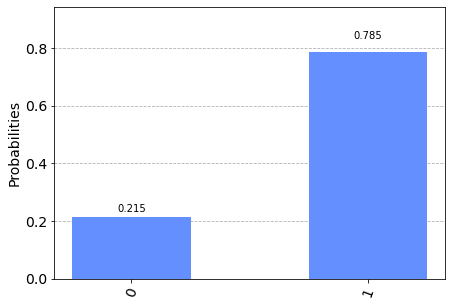

In [2]:
backend = q.Aer.get_backend("aer_simulator")  # Get the quantum backend
job = backend.run(circuit)  # Run the job

counts = job.result().get_counts()  # Get the results (counts)
q.visualization.plot_histogram(counts)  #Visualise the counts

We can see that the expectation comes true. We measure the $|1\rangle$ state in approximately 80\% of the times. Note that this is not exact, this is because by measuring, we're approximating the value of $\beta$ using a random (quantum) process. The approximation of $\beta$ will be better when repeating the experiment more often.

## Transition probabilities

### XOR

One important feature of quantum computers is the ability to construct multi-qubit gates. These allow us to create links between qubit states, this is called entanglement. In the figure of the climate risk model above, for example, we see that event 0 and event 1 are _always the opposite_ (XOR or exclusive OR). On a quantum computer, the XOR can be achieved by using a controlled-NOT gate. The controlled-NOT gate flips the state of a target qubit (in state $|\psi\rangle = \alpha |0\rangle + \beta |1\rangle$ if and only if a control qubit is in the $|1\rangle$ state, i.e.

$$ CNOT|0\psi\rangle = |0\psi\rangle ,$$

$$ CNOT |1\psi\rangle = CNOT |1\rangle (\alpha |0\rangle + \beta |1\rangle) = |1\rangle (\alpha |1\rangle + \beta |0\rangle).$$

Note that interesting quantum states arise when the control qubit is in a superposition. Now we will implement the XOR to implement the first two risk items of the model.

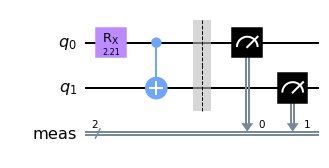

In [3]:
# A new quantum circuit with 2 qubits
circuit = q.QuantumCircuit(2)

# Add the x-rotation gate to qubit 0
circuit.rx(theta, 0)

# Add the CNOT to implement the XOR
circuit.cnot(0,1)

# Measure the qubits to get the output
circuit.measure_all()

# Draw the circuit with matplotlib
circuit.draw(output='mpl')

And again, we can run this circuit and measure its outcomes.

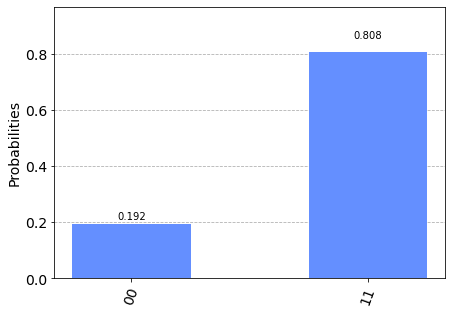

In [4]:
job = backend.run(circuit)  # Run the job

counts = job.result().get_counts()  # Get the results (counts)
q.visualization.plot_histogram(counts)  #Visualise the counts

That doesn't look good! Now the qubits are always the same. Because qubit 1 started in the $|0\rangle$-state, when it was flipped (i.e. when qubit 0 was in the $|1\rangle$-state), it also became $|1\rangle$. We need exactly the opposite behaviour, which can be achieved multiple ways. For consistency later on, we will alter the method in the following way: we change the CNOT-gate a bit, such that it flips the target qubit when the control is in the $|0\rangle$ state.

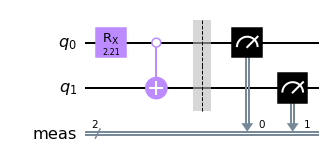

In [5]:
# The same circuit as above
circuit = q.QuantumCircuit(2)
circuit.rx(theta, 0)

# Add the CNOT with the control state as '0'
circuit.cnot(0,1, ctrl_state='0')

# Measure the qubits to get the output
circuit.measure_all()

# Draw the circuit with matplotlib
circuit.draw(output='mpl')

Now we measure:

/opt/homebrew/Caskroom/miniforge/base/envs/riskmodel/lib/python3.8/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/Caskroom/miniforge/base/envs/riskmodel/lib/python3.8/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


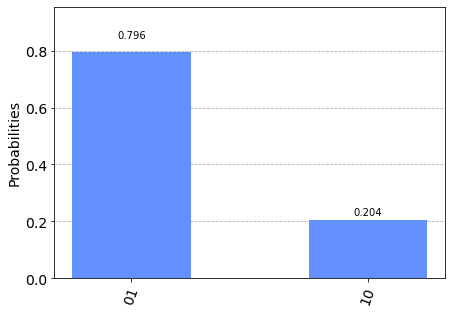

In [6]:
# The not-controlled-not gate is not available on all backends, so the circuit must be transpiled first.
# We will keep this step in general as we're using more gates that are unavailable on all backends.
circuit_transpiled = q.transpile(circuit, backend=backend)

job = backend.run(circuit_transpiled)  # Run the job

counts = job.result().get_counts()  # Get the results (counts)
q.visualization.plot_histogram(counts)  #Visualise the counts

That looks better! The qubits are always the opposite and the probabilities are taken into account.

### Controlled rotation


We've got the first part covered: we can implement probabilities and XORs. In the climate risk, the important feature is that the occurence of one event, for example flooding, impacts the probabilities that other events occur. This feature can be implemented in a circuit by a controlled rotation. A controlled rotation applies a rotation to a target qubit when the control qubit is in a state. In the example, when the qubit for 'flooding' is in the $|1\rangle$-state, there is a 40\% probability that buildings will flood. This looks like the following:

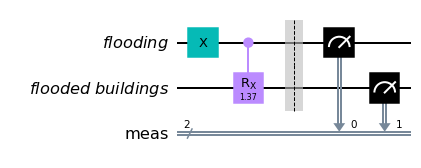

In [7]:
# Make separate quantum qubits for the naming
flooding = q.QuantumRegister(1, name='flooding')
fld_buildings = q.QuantumRegister(1, name='flooded buildings')

# Create the circuit
circuit = q.QuantumCircuit(flooding, fld_buildings)

# Bring flooding in the 1 state
circuit.x(flooding)

# Get transition probability
transition_p = 0.4
theta_trans = 2 * np.arcsin(np.sqrt(0.4))

# Control rotate the 'flooded buidlings' qubit
circuit.crx(theta_trans, flooding, fld_buildings)

# Measure the qubits to get the output
circuit.measure_all()

# Draw the circuit with matplotlib
circuit.draw(output='mpl')

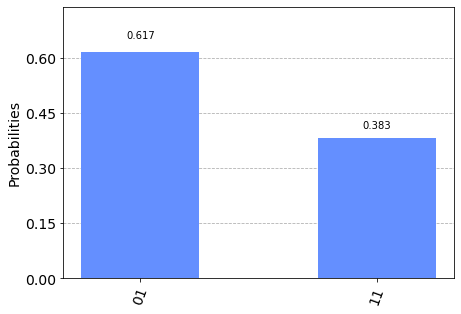

In [8]:
# Transpilation
circuit_transpiled = q.transpile(circuit, backend=backend)

job = backend.run(circuit_transpiled)  # Run the job

counts = job.result().get_counts()  # Get the results (counts)
q.visualization.plot_histogram(counts)  #Visualise the counts

This is what we want: approximately 40\% of the time, they both happen.

The intrinsic probabilities of the risk items make the model somewhat more complex. When 'flooding' is in the $|1\rangle$ state, 'flooded buidlings' can happen because of a transition, or because of the intrinsic probability (or both). This means the $P$ used to control $\theta$ must be altered according to the rules of probability. Also, there must be a controlled rotation for when the control qubit is in the $|1\rangle$-state, but also for the $|0\rangle$-state. The probabilities that should be encoded in these controlled rotations can be found as follows:

$$ P(\text{target risk item occurs }| \text{control risk item occurs}) = 1 - P(\text{target risk item does not occur }| \text{control risk item occurs}),$$

$$ P(\text{target risk item does not occur }| \text{control risk item occurs}) = P(\text{not occuring by intrinsic p}) \cdot P(\text{not occuring by transition}) = (1-P_{intrisic})(1 - P_{transition}) , $$

and we have

$$ P(\text{target risk item occurs }| \text{control risk item does not occur}) = P_{intrisic} . $$

We can now combine all of this to implement the entire risk model in the quantum circuit.

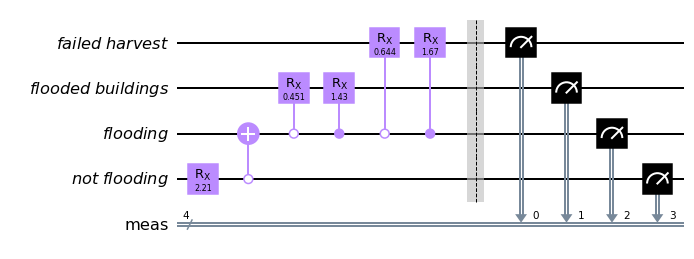

In [15]:
# Make separate quantum qubits (for the naming)
not_flooding = q.QuantumRegister(1, name='not flooding')
flooding = q.QuantumRegister(1, name='flooding')
fld_buildings = q.QuantumRegister(1, name='flooded buildings')
failed_h = q.QuantumRegister(1, name='failed harvest')

# Helper converter function
p_to_theta = lambda x: 2*np.arcsin(np.sqrt(x))

# Create the circuit
circuit = q.QuantumCircuit(failed_h, fld_buildings, flooding, not_flooding)

# Intrinsic not flooding
circuit.rx(p_to_theta(0.8), not_flooding)

# Add the CNOT with the control state as '0'
circuit.cnot(not_flooding, flooding, ctrl_state='0')

# The intrinsic probability for flooded buildings occurs when there's no flooding
circuit.crx(p_to_theta(0.05), flooding, fld_buildings, ctrl_state='0')

# Calculate the P(fld buidlings | flooding)
p = 1 - (1 - 0.05) * (1 - 0.4)
circuit.crx(p_to_theta(p), flooding, fld_buildings, ctrl_state='1')

# The same for failed harvest
circuit.crx(p_to_theta(0.1), flooding, failed_h, ctrl_state='0')
p = 1 - (1 - 0.1) * (1 - 0.5)
circuit.crx(p_to_theta(p), flooding, failed_h, ctrl_state='1')

# Measure the qubits to get the output
circuit.measure_all()

# Draw the circuit with matplotlib
circuit.draw(output='mpl')

And now this is our risk model. The 4 qubits are now in an entangled, superposition state corresponding to the risk model. Using the quantum circuit, the probabilities of risk items occuring can be estimated. 

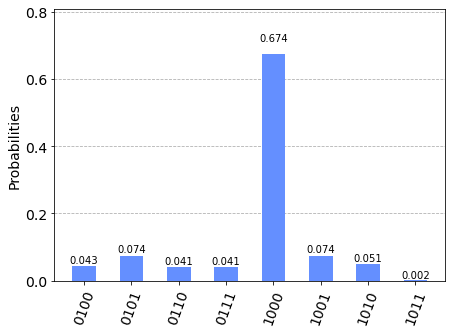

In [17]:
# Transpilation
circuit_transpiled = q.transpile(circuit, backend=backend)

job = backend.run(circuit_transpiled)  # Run the job

counts = job.result().get_counts()  # Get the results (counts)
q.visualization.plot_histogram(counts)  #Visualise the counts

## Conclusion

To conclude, we started with a risk model where risk items had intrinsic and transition probabilities. Using rotation gates and controlled rotation gates, we managed to encode the risk model in a quantum circuit. The quantum circuit has as many qubits as there are risk items in the model and it has two controlled gates for every _link_ in the model.

From this, we can go different routes. For example, we can use an adder circuit to add all the impacts of the risk events. This allows for the assessment of the financial risk coming from the risk model. We can also add factors like climate change, that will have a transition probability to, for example, flooding. These additions to the model remain the subject for future blogs.